### This notebook involves the **Customer Behaviour Analysis on ecommerce website using machine learning**.

### Install required libraries

In [ ]:
!pip install eli5
!pip install scikit-plot

     |████████████████████████████████| 112kB 8.0MB/s 


### Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm 
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report,auc
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the dataset
df=pd.read_csv('Dataset.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


#### **Dataset information**:
The dataset consists of feature vectors belonging to **12,330** sessions. The dataset was formed
so that each session would belong to a different user in a **1-year period** to avoid any tendency
to a specific campaign, special day, user profile, or period.

#### **Attribute information**:
* "Administrative", "AdministrativeDuration", "Informational",
"Informational Duration", "Product Related" and "Product Related Duration" - Represent the **number of different types of pages visited by the visitor** in that session and **total time spent** in
each of these page categories.
* "Bounce Rate", "Exit Rate" and "Page Value" - Represent
the metrics measured by **"Google Analytics"** for each page in the e-commerce site.
* "Bounce Rate"  -  It refers to the **percentage of visitors** who enter your website from
other **web page** and then **leave ("bounce") without triggering any other requests** to the analytics server
during that session.
*  "Exit Rate" - It means **how often visitors exit from a particular page** after visiting **any number of pages on the site** in the same session. As a percentage, exit rate is calculated as the **number of exits / number of pageviews for a particular page**.
* "Page Value"  - It is the average value for a page that a user visited before landing on the **goal page** or completing an **Ecommerce transaction (or both)**. This value is intended to give you an **idea of which page in your site contributed more to your site's revenue**.
* "Special Day" - It indicates the **closeness of the site** visiting time
to a specific **special day** (e.g. Mother‟s Day, Valentine's Day) in which the sessions are more
likely to be finalized with transaction. The value of this attribute is determined by considering
the **dynamics of e-commerce** such as the duration between the **order date and delivery date**.
* "Browser" - It means **No. of Browsers users** used during shopping.
* "Revenue" - It is a target variable (**Revenue adds or not**)
* "TrafficType" - Type of traffic (Organic, CPC(Cost per click), Referral, & Direct) 	


In [ ]:
print(f'There are {df.shape[0]} observations (sessions) & {df.shape[1]} features in the dataset.')

There are 12330 observations (sessions) & 18 features in the dataset.


### **Descriptive statistics**

In [ ]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


**Let's look at the missing (null) values & data types in the dataset**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

It seems all columns have non-null values i.e., no missing values in the dataset. The attributes "Month", & "VisitorType" are of Object type, which need to be converted into categorical type.

### **Exploratory Data Analysis (EDA)**

#### Distribution of classes in Revenue attribute (target variable)

Count of Revenue classes :
 False    10422
True      1908
Name: Revenue, dtype: int64
percentage of count of Revenue classes :
 False    84.525547
True     15.474453
Name: Revenue, dtype: float64
CPU times: user 114 ms, sys: 67.2 ms, total: 181 ms
Wall time: 135 ms


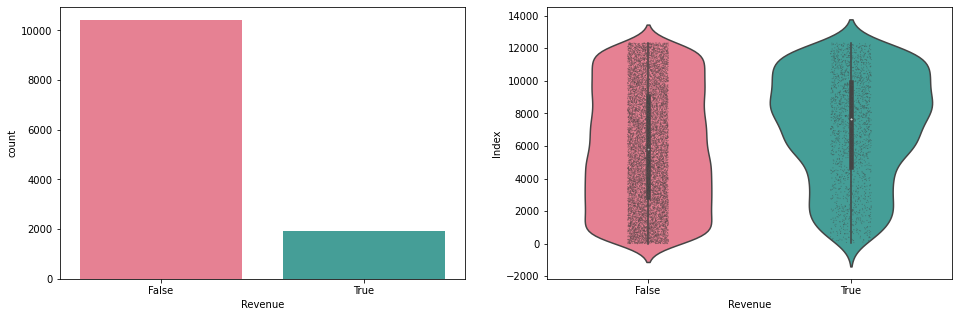

In [ ]:
%%time
#Revenue classes count
df_class=df['Revenue'].value_counts()
print('Count of Revenue classes :\n',df_class)
#Percentage of Revenue classes count
per_revenue_class=df['Revenue'].value_counts()/len(df)*100
print('percentage of count of Revenue classes :\n',per_revenue_class)

#Countplot and violin plot for Revenue classes
fig,ax=plt.subplots(1,2,figsize=(16,5))
sns.countplot(df.Revenue.values,ax=ax[0],palette='husl')
sns.violinplot(x=df.Revenue.values,y=df.index.values,ax=ax[1],palette='husl')
sns.stripplot(x=df.Revenue.values,y=df.index.values,jitter=True,color='black',linewidth=0.5,size=0.5,alpha=0.5,ax=ax[1],palette='husl')
ax[0].set_xlabel('Revenue')
ax[1].set_xlabel('Revenue')
ax[1].set_ylabel('Index')

**Take aways:**                   
* We have highly imbalanced data, where 84.5% of the data is the number of customers those will not add any revenue and 15.5% of the data is those who will add revenue to the company.
* If you look at the jitter in violin plot, we can say that Revenue classes distributed  uniformly over the indexs of the dataframe and Also we can observe the imbalanced class distribution where the false class is most densely distributed than the True class.

For more details about Violin plots, check [here](https://towardsdatascience.com/violin-plots-explained-fb1d115e023d).

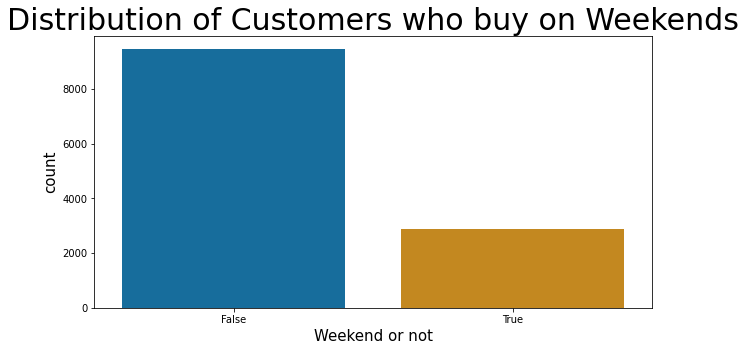

In [ ]:
#displaying the purchase on weekend
plt.rcParams['figure.figsize'] = (10, 5)
sns.countplot(df['Weekend'], palette = 'colorblind')
plt.title('Distribution of Customers who buy on Weekends', fontsize = 30)
plt.xlabel('Weekend or not', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.show()

In [ ]:
#displaying the count of visitor type
df['VisitorType'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

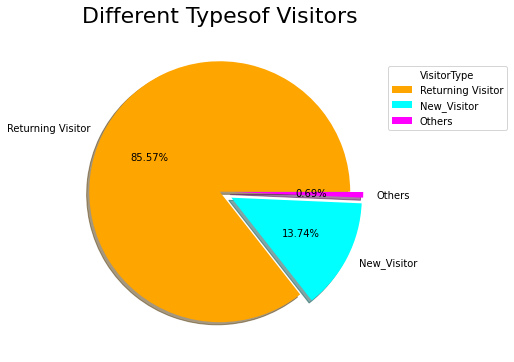

In [ ]:
#displaying customer type and their count
size = [10551, 1694, 85]
colors = ['orange', 'cyan', 'magenta']
labels = "Returning Visitor", "New_Visitor", "Others"
explode = [0, 0.1, 0.1]

plt.figure(figsize=(12,6))
plt.pie(size, colors = colors, labels = labels, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Different Typesof Visitors', fontsize = 22)
plt.axis('off')
plt.legend(title='VisitorType',bbox_to_anchor=(1,0.9))
plt.show()

In [ ]:
#displaying the count of browser
df['Browser'].value_counts()

2     7961
1     2462
4      736
5      467
6      174
10     163
8      135
3      105
13      61
7       49
12      10
11       6
9        1
Name: Browser, dtype: int64

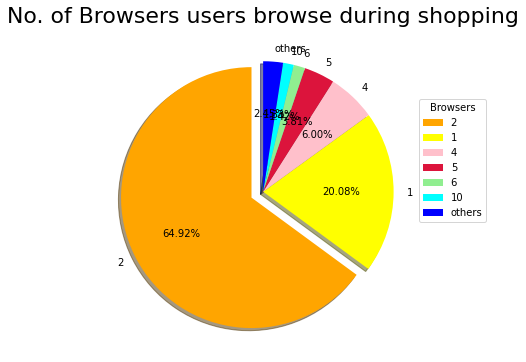

In [ ]:
#displaying the different browsers and their count
size = [7961, 2462, 736, 467,174, 163, 300]
colors = ['orange', 'yellow', 'pink', 'crimson', 'lightgreen', 'cyan', 'blue']
labels = "2", "1","4","5","6","10","others"
explode = [0.1, 0, 0, 0, 0, 0, 0]

plt.figure(figsize=(12,6))
plt.pie(size, colors = colors, labels = labels, explode = explode, shadow = True, autopct = '%.2f%%', startangle = 90)
plt.title('No. of Browsers users browse during shopping', fontsize = 22)
plt.axis('off')
plt.legend(title='Browsers',bbox_to_anchor=(1.2,0.8))
plt.show()

In [ ]:
#displaying the count of month
df['Month'].value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

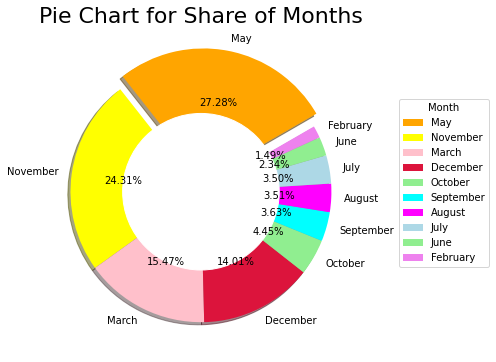

In [ ]:
#displaying the different month and their count
size = [3364, 2998, 1907, 1727, 549, 448, 433, 432, 288, 184]
colors = ['orange', 'yellow', 'pink', 'crimson', 'lightgreen', 'cyan', 'magenta', 'lightblue', 'lightgreen', 'violet']
labels = "May", "November", "March", "December", "October", "September", "August", "July", "June", "February"
explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

circle = plt.Circle((0, 0), 0.6, color = 'white')

plt.figure(figsize=(12,6))
plt.pie(size, colors = colors, labels = labels, explode = explode, shadow = True, autopct = '%.2f%%',startangle = 30)
plt.title('Pie Chart for Share of Months', fontsize = 22)
p = plt.gcf()
p.gca().add_artist(circle)
plt.axis('off')
plt.legend(title='Month',bbox_to_anchor=(1.4,0.8))
plt.show()

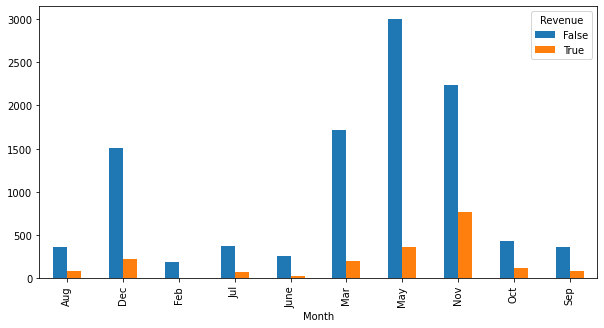

In [ ]:
#displaying the revenue monthwise
ct2= pd.crosstab(df.Month, df.Revenue)
ct2.plot.bar()
plt.legend(title='Revenue')

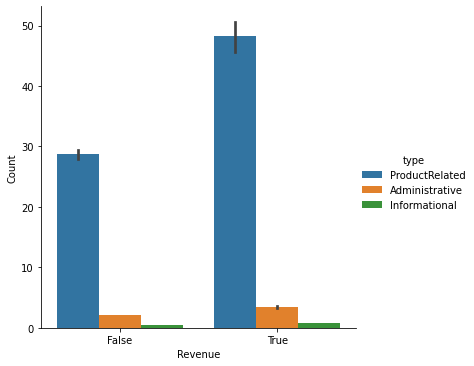

In [ ]:
#displaying the count for productrelated,administrative and informational based on revenue
df2 = pd.melt(df[['ProductRelated','Administrative','Informational','Revenue']], id_vars='Revenue', var_name="type", value_name="Count")
sns.factorplot(x='Revenue', y='Count', hue='type', data=df2, kind='bar')

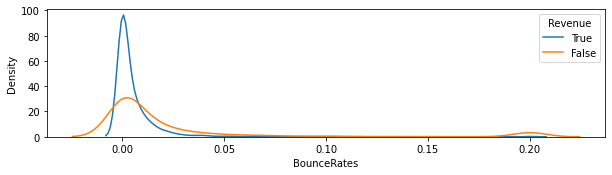

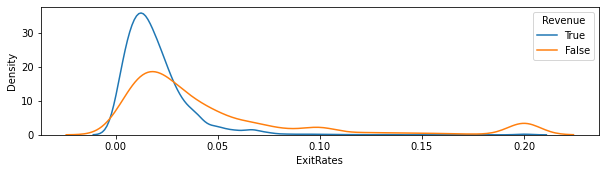

In [ ]:
#displaying count of bounce rate and exit rate based on revenue
plt.figure(figsize=(10,8))

ax1 = plt.subplot(311)
sns.kdeplot(df[df.Revenue == True].BounceRates)
sns.kdeplot(df[df.Revenue == False].BounceRates)
plt.xlabel('BounceRates')
plt.legend(title='Revenue', loc='upper right', labels=['True', 'False'])

plt.figure(figsize=(10,8))
ax2 = plt.subplot(312)
sns.kdeplot(df[df.Revenue == True].ExitRates)
sns.kdeplot(df[df.Revenue == False].ExitRates)
plt.xlabel('ExitRates')
plt.legend(title='Revenue', loc='upper right', labels=['True', 'False'])
plt.show()

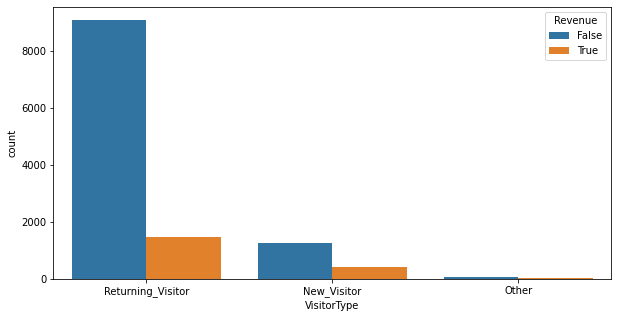

In [ ]:
#plotting the visitortype based on revenue
sns.countplot(x="VisitorType",data=df,hue="Revenue")

### **Data Pre-processing**

In [ ]:
#Convert object to categorical type
df['Month']=df['Month'].astype('category')
df['VisitorType'] = df['VisitorType'].astype('category')

In [ ]:
# Encode categorical variables using Label Encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

for col in ['Month','VisitorType']:
  df[col]=le.fit_transform(df[col])

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,True,False


In [ ]:
# Map 0 for False & 1 for True 
Revenue_map={False:0,True:1}
df['Revenue']=df['Revenue'].map(Revenue_map)
Weekend_map={False:0,True:1}
df['Weekend']=df['Weekend'].map(Weekend_map)
df.head(100)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,2,1,1,1,1,2,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,2,2,2,1,2,2,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,2,4,1,9,3,2,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,2,3,2,2,4,2,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,2,3,3,1,4,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0.0,0,0.0,2,33.000000,0.000000,0.100000,0.0,0.2,2,1,1,1,3,2,0,0
96,0,0.0,0,0.0,6,1566.500000,0.050000,0.066667,0.0,0.2,2,1,1,1,3,2,0,0
97,0,0.0,0,0.0,4,105.000000,0.000000,0.025000,0.0,0.6,2,1,1,1,4,2,0,0
98,0,0.0,1,0.0,7,50.000000,0.038095,0.080952,0.0,0.6,2,2,4,1,7,2,0,0


In [ ]:
# Create X & y (Revenue) set
X=df.drop(['Revenue'],axis=1)
y=df['Revenue']

In [ ]:
# Scale our continuous data in the range of 0 & 1
# define min max scaler
scaler = MinMaxScaler()
# transform data
X_scaled = scaler.fit_transform(X)

### **Feature Engineering**

#### **How attributes are correlated?**

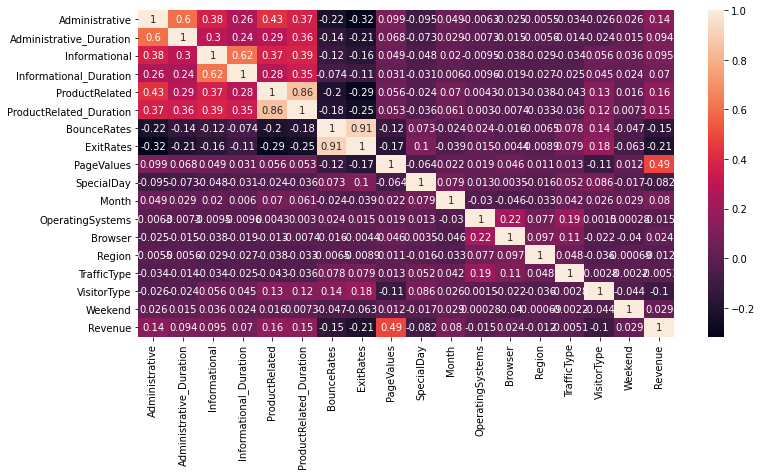

In [ ]:
# Correlation plot using Heatmaps
df_corr=df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(df_corr,annot=True,fmt='.2g')

From above plot, we can say that the attributes Bounce rates & Exit rates are highly correlated (0.91) i.e., mutually collinear. So we can drop one variable (Bounce rates or Exit rates) from the dataset.

#### Chi-Square test for selecting best features

A chi-square test is used in statistics to test the independence of two events. In our case, we used to determine the relationship between independent variables (features) & dependent variable (response or target). In simple words, higher the Chi-Square value the feature is more dependent on the response and it can be selected for model training.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
bestfeatures = SelectKBest(score_func=chi2, k=15)
bf = bestfeatures.fit(X_scaled,y)
dfscores = pd.DataFrame(bf.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [ ]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['features','Score'] 
print(featureScores.nlargest(18,'Score'))

                   features       Score
8                PageValues  484.091655
6               BounceRates  148.271680
7                 ExitRates  144.925360
9                SpecialDay   53.797094
0            Administrative   41.998723
4            ProductRelated   27.400405
15              VisitorType   18.773761
2             Informational   14.915900
3    Informational_Duration   13.752302
5   ProductRelated_Duration   13.715117
1   Administrative_Duration   12.285351
10                    Month    9.573744
16                  Weekend    8.120464
12                  Browser    1.284311
13                   Region    0.556515
11         OperatingSystems    0.279977
14              TrafficType    0.089538


We can say that, the attributes 'OperatingSystems', 'TrafficType', & 'Region' are not that important for predicting the Revenue(True/False). So, we can drop these features from our dataset. 

#### Permutation importance for feature selection

It measures the importance of a feature by calculating the increase in the **model's prediction error** after **permuting** the feature. A feature is "**important**" if shuffling its values **increases the model error**, because in this case the model relied on the feature for the prediction. A feature is "**unimportant**" if shuffling its values leaves the **model error unchanged**, because in this case the model ignored the feature for the prediction.

For more details check [here](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

Let us build simple model to find features which are more important.

In [ ]:
#Split the data into train (80%), validation(10%), & test set (10%).
X_train,X_test,y_train,y_test=train_test_split(X, y, random_state=42, test_size=0.2)
X_val,X_test,y_val,y_test=train_test_split(X_test, y_test, random_state=42, test_size=0.5)

print('Shape of X_train :',X_train.shape)
print('Shape of X_val :',X_val.shape)
print('Shape of X_test :',X_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_val :',y_val.shape)
print('Shape of y_test :',y_test.shape)

Shape of X_train : (9864, 17)
Shape of X_val : (1233, 17)
Shape of X_test : (1233, 17)
Shape of y_train : (9864,)
Shape of y_val : (1233,)
Shape of y_test : (1233,)


**Random forest classifier** - Base Classifier for Permutation importance

In [ ]:
#Random forest classifier
rf_model=RandomForestClassifier(n_estimators=10,random_state=42)
#fitting the model
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Let us calculate weights and show important features using eli5 library.

In [ ]:
#Permutation importance
from eli5.sklearn import PermutationImportance
perm_imp=PermutationImportance(rf_model, random_state=42)
#fitting the model
perm_imp.fit(X_val,y_val);

Let us see the important features,

In [ ]:
import eli5
#Important features
eli5.show_weights(perm_imp,feature_names=X.columns.tolist())

Weight,Feature
0.1046 ± 0.0138,PageValues
0.0032 ± 0.0049,Month
0.0021 ± 0.0043,ExitRates
0.0005 ± 0.0055,Informational_Duration
0.0003 ± 0.0053,Informational
0.0000 ± 0.0027,Weekend
0.0000 ± 0.0010,SpecialDay
-0.0008 ± 0.0051,VisitorType
-0.0018 ± 0.0090,Region
-0.0019 ± 0.0060,OperatingSystems


Insights:
* **PageValues** is the most important feature &  **SpecialDay** is the least important attribute among all features.

### **Building ML models for Revenue prediction**

We are building 3 ML models for this project:
* Logistic Regression as a Base Classifier
* LGBM (**L**ight **G**radient **B**oosting **M**achine)
* XGBM (e**X**tream **G**radient **B**oosting **M**achine)

We build above 3 models on raw data & sampling data (SMOTE)

### Building ML models on raw data (without SMOTE)

In [ ]:
from sklearn.linear_model import LogisticRegression
#Logistic regression model
lr_model=LogisticRegression(random_state=42)
#fitting the lr model
lr_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Accuracy of the model
lr_score=lr_model.score(X_train,y_train)
print('Accuracy of the trained lr_model :',lr_score)

Accuracy of the trained lr_model : 0.8855433901054339


In [ ]:
%%time
#Cross validation prediction for Logistic prediction
cv_predict=cross_val_predict(lr_model,X_test,y_test,cv=5)
#Cross validation score
cv_score=cross_val_score(lr_model,X_test,y_test,cv=5)
print('cross_val_score :',np.average(cv_score))

cross_val_score : 0.8694183864915572
CPU times: user 549 ms, sys: 427 ms, total: 976 ms
Wall time: 517 ms


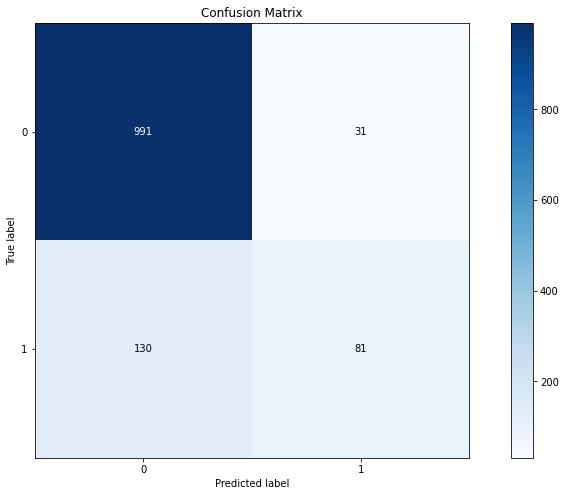

In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test, cv_predict)
#Plot the confusion matrix
plot_confusion_matrix(y_test, cv_predict, normalize=False,figsize=(15,8))

In [ ]:
class_report= classification_report(y_test, cv_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1022
           1       0.72      0.38      0.50       211

    accuracy                           0.87      1233
   macro avg       0.80      0.68      0.71      1233
weighted avg       0.86      0.87      0.85      1233



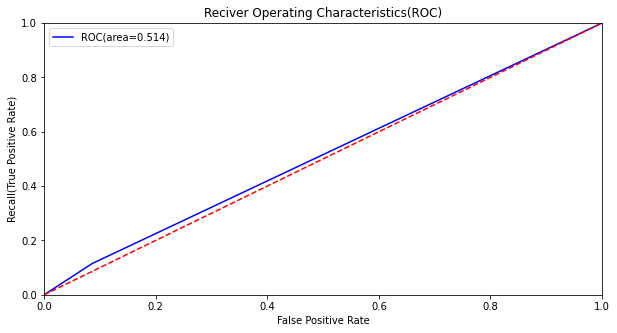

AUC: 0.5144215876089061


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_val,cv_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* AUC of 0.514 means the model is just making random guesses. This is because the recall value for class 1 is very low i.e., 0.38. So model is having difficulty in predicting class 1 correctly due to our training data has very low number of class 1 samples than class 0 , i.e., highly imbalanced data.

**LightGBM model**

In [ ]:
#Creating datasets for LGBM
#training data
lgb_train=lgb.Dataset(X_train,label=y_train)
#validation data
lgb_val=lgb.Dataset(X_val,label=y_val)
#test data
lgb_test=lgb.Dataset(X_test,label=y_test)

In [ ]:
#Selecting best hyperparameters by tuning of different parameters
params={'boosting_type': 'gbdt', 
          'max_depth' : -1, #no limit for max_depth if <0
          'objective': 'binary',
          'metric':'auc',
          'num_leaves': 50,
          'learning_rate': 0.01,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'lambda_l2':0.01,
          'min_split_gain': 0.45, #>0
          'min_child_weight': 1,
          'min_child_samples': 5,
          'random_state':42
          }

In [ ]:
num_rounds=10000
lgbm= lgb.train(params,lgb_train,num_rounds,valid_sets=[lgb_train,lgb_val],verbose_eval=1000,early_stopping_rounds = 5000)
lgbm

Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.979953	valid_1's auc: 0.925024
[2000]	training's auc: 0.979953	valid_1's auc: 0.925024
[3000]	training's auc: 0.979953	valid_1's auc: 0.925024
[4000]	training's auc: 0.979953	valid_1's auc: 0.925024
[5000]	training's auc: 0.979953	valid_1's auc: 0.925024
Early stopping, best iteration is:
[49]	training's auc: 0.952167	valid_1's auc: 0.926728


In [ ]:
# model prediction
#probability predictions
lgbm_predict_prob=lgbm.predict(X_test,random_state=42,num_iteration=lgbm.best_iteration)
#Convert to binary output 1 or 0
lgbm_predict=np.where(lgbm_predict_prob>=0.5, 1, 0)
print(lgbm_predict_prob)
print(lgbm_predict)

[0.16057133 0.09884246 0.09476339 ... 0.31731165 0.09464857 0.33180357]
[0 0 0 ... 0 0 0]


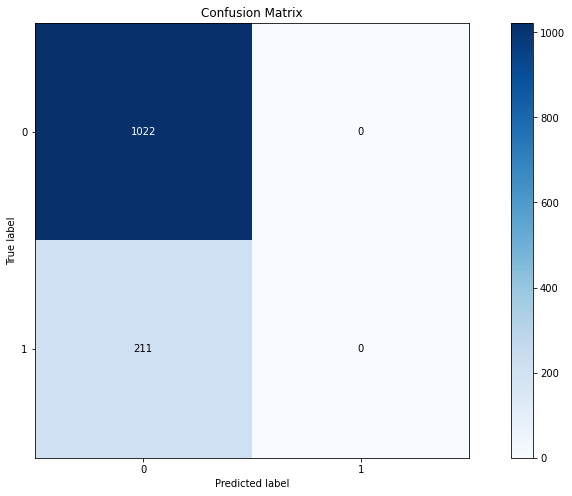

In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test, lgbm_predict )
#Plot the confusion matrix
plot_confusion_matrix(y_test, lgbm_predict, normalize=False,figsize=(15,8))

In [ ]:
class_report= classification_report(y_test, lgbm_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1022
           1       0.00      0.00      0.00       211

    accuracy                           0.83      1233
   macro avg       0.41      0.50      0.45      1233
weighted avg       0.69      0.83      0.75      1233



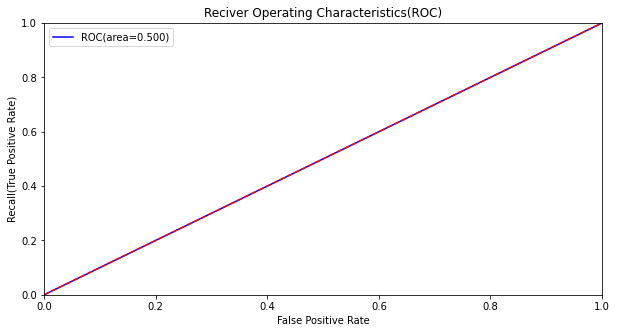

AUC: 0.5


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test,lgbm_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* Surprisingly, LGBM giving 0 recall for class 1, which means the model not at all learning class 1 during training. It seems our LGBM model is very sensitive to highly imbalanced data.

**XGBoost**

In [ ]:
import xgboost as xgb

#Creating datasets for XGboost
#training data
xgb_train=xgb.DMatrix(X_train,label=y_train, feature_names=X.columns.tolist())
#validation data
xgb_val=xgb.DMatrix(X_val,label=y_val,feature_names=X.columns.tolist())
#validation data
xgb_test=xgb.DMatrix(X_test,label=y_test, feature_names=X.columns.tolist())

In [ ]:
#Selecting best hyperparameters by tuning of different parameters
param={'boosting_type': 'gbtree', 
          'max_depth' : 6,
          'objective': 'binary:logistic',
          'metric':'auc',
          'num_leaves': 30,
          'learning_rate': 0.01,
          'subsample': 0.8,
          'subsample_freq': 10,
          'colsample_bytree': 0.8,
          'bagging_fraction':0.8,
          'bagging_freq':5,
          'lambda_l2':0.4,
          'min_child_samples': 15,
          #'is_unbalance':True
          }

In [ ]:
num_round = 1000
evallist = ([(xgb_val, 'eval'),(xgb_train, 'train')])
bst = xgb.train(param, xgb_train, num_round, evallist,early_stopping_rounds=100)
bst

[0]	eval-error:0.117599	train-error:0.088706
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 100 rounds.
[1]	eval-error:0.127332	train-error:0.098236
[2]	eval-error:0.108678	train-error:0.086476
[3]	eval-error:0.128143	train-error:0.094485
[4]	eval-error:0.111111	train-error:0.089011
[5]	eval-error:0.111922	train-error:0.086071
[6]	eval-error:0.108678	train-error:0.083232
[7]	eval-error:0.109489	train-error:0.082522
[8]	eval-error:0.107056	train-error:0.081711
[9]	eval-error:0.107867	train-error:0.083739
[10]	eval-error:0.111922	train-error:0.084955
[11]	eval-error:0.109489	train-error:0.083333
[12]	eval-error:0.107056	train-error:0.082218
[13]	eval-error:0.106245	train-error:0.081204
[14]	eval-error:0.111111	train-error:0.082725
[15]	eval-error:0.107867	train-error:0.081914
[16]	eval-error:0.111111	train-error:0.082624
[17]	eval-error:0.107056	train-error:0.082522
[18]	eval-error:0.107867	train-err

In [ ]:
# model prediction
#probability predictions
xgbm_pred_prob = bst.predict(xgb_test, ntree_limit=bst.best_ntree_limit)
#Convert to binary output 1 or 0
xgbm_predict=np.where(xgbm_pred_prob>=0.5, 1, 0)
print(xgbm_pred_prob)
print(xgbm_predict)

[0.21917877 0.00346872 0.00419892 ... 0.636937   0.00146003 0.5892667 ]
[0 0 0 ... 1 0 1]


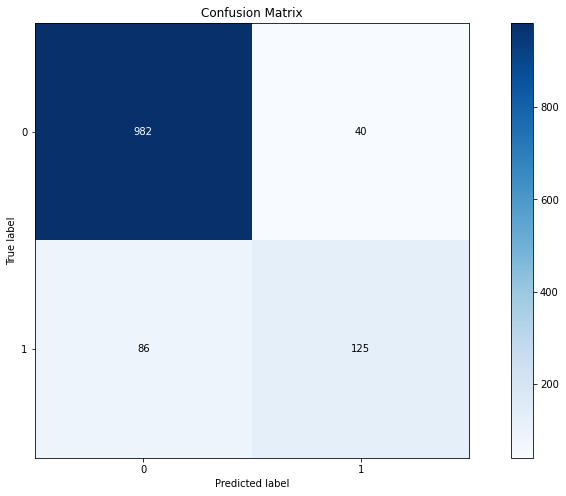

In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test, xgbm_predict )
#Plot the confusion matrix
plot_confusion_matrix(y_test, xgbm_predict, normalize=False,figsize=(15,8))

In [ ]:
class_report= classification_report(y_test, xgbm_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1022
           1       0.76      0.59      0.66       211

    accuracy                           0.90      1233
   macro avg       0.84      0.78      0.80      1233
weighted avg       0.89      0.90      0.89      1233



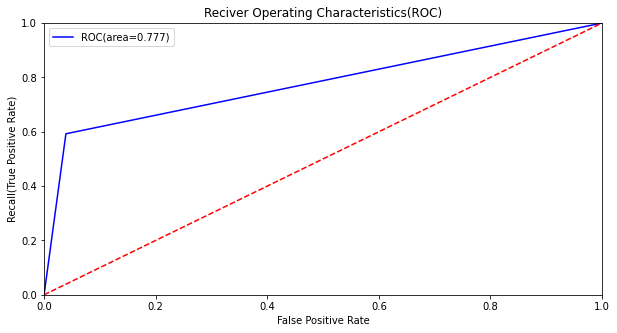

AUC: 0.7766390591814211


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test,xgbm_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* XGBM is performed better than LGBM & Logistic models with recall value of 0.59. It means XGBM has the capability to handle highly imbalanced data.

Overall, all models having difficulty in classifying class 1 correctly due to the presence of highly imbalanced data during training. We will overcome this difficuly by using SMOTE, a sampling technique.

### **Handling imbalanced data**
Since our data is imbalanced one, we need to balance the data in order to get better accurate results from our ML models. To balance the data, we are using SMOTE (Synthetic Minority OverSampling Technique). SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

For more details SMOTE, checke [here](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter= Counter(y_train)
print(f'Before Sampling', counter)
# Oversampling the train data using SMOTE
smt=SMOTE()
X_train_sm,y_train_sm = smt.fit_resample(X_train,y_train)
counter= Counter(y_train_sm)
print('After Sampling', counter)

Before Sampling Counter({0: 8367, 1: 1497})
After Sampling Counter({0: 8367, 1: 8367})


### **Base Classifier (Logistic Regression) model**

In [ ]:
from sklearn.linear_model import LogisticRegression
#Logistic regression model
lr_model=LogisticRegression(random_state=42)
#fitting the lr model
lr_model.fit(X_train_sm,y_train_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Accuracy of the model
lr_score=lr_model.score(X_train_sm,y_train_sm)
print('Accuracy of the trained lr_model :',lr_score)

Accuracy of the trained lr_model : 0.8309429903191108


In [ ]:
%%time
#Cross validation prediction for Logistic prediction
cv_predict=cross_val_predict(lr_model,X_test,y_test,cv=5)
#Cross validation score
cv_score=cross_val_score(lr_model,X_test,y_test,cv=5)
print('cross_val_score :',np.average(cv_score))

cross_val_score : 0.8694183864915572
CPU times: user 549 ms, sys: 438 ms, total: 987 ms
Wall time: 529 ms


Accuracy of the model is not the best metric to use when evaluating the model on imbalanced datasets as it may be misleading. So, we are going to use Confusion matrix, & AUC score from ROC for checking model performance.

**Confusion matrix**

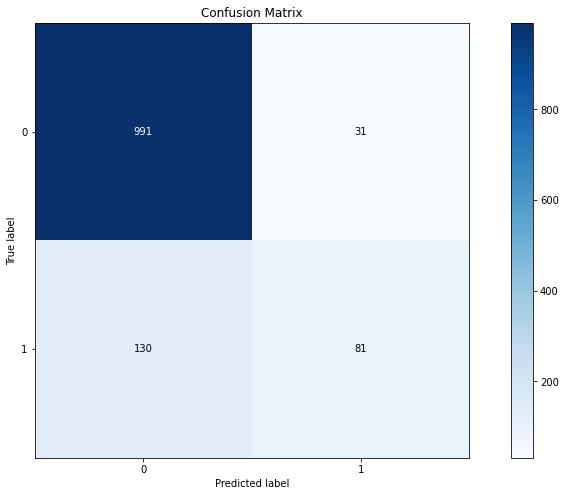

In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test, cv_predict)
#Plot the confusion matrix
plot_confusion_matrix(y_test, cv_predict, normalize=False,figsize=(15,8))

#### **Classification Report**

In [ ]:
class_report= classification_report(y_test, cv_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1022
           1       0.72      0.38      0.50       211

    accuracy                           0.87      1233
   macro avg       0.80      0.68      0.71      1233
weighted avg       0.86      0.87      0.85      1233



**Reciever operating characteristics (ROC)- Area under curve(AUC) score**

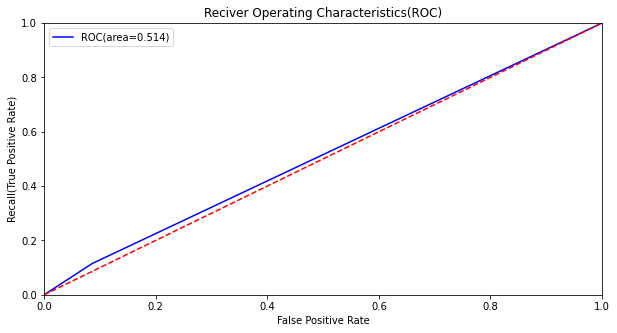

AUC: 0.5144215876089061


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_val,cv_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* SMOTE sampling is not making any significant changes in the performance of Logistic model. This may due to the non-linear behaviour of the data.

### **LGBM model**

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

The trees in LightGBM have a leaf-wise growth, rather than a level-wise growth. After the first split, the next split is done only on the leaf node that has a higher delta loss.

In [ ]:
#Creating datasets for LGBM
#training data
lgb_train=lgb.Dataset(X_train_sm,label=y_train_sm)
#validation data
lgb_val=lgb.Dataset(X_val,label=y_val)
#test data
lgb_test=lgb.Dataset(X_test,label=y_test)

**choosing  hyperparameters**

In [ ]:
#Selecting best hyperparameters by tuning of different parameters
params={'boosting_type': 'gbdt', 
          'max_depth' : -1, #no limit for max_depth if <0
          'objective': 'binary',
          'metric':'auc',
          'num_leaves': 50,
          'learning_rate': 0.008,
          'subsample_for_bin': 100,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'bagging_fraction':0.8,
          'bagging_freq':5,
          'lambda_l2':0.05,
          'min_split_gain': 0.45, #>0
          'min_child_weight': 1,
          'min_child_samples': 5,
          }

 **Training LGBM model**

In [ ]:
num_rounds=10000
lgbm= lgb.train(params,lgb_train,num_rounds,valid_sets=[lgb_train,lgb_val],verbose_eval=1000,early_stopping_rounds = 5000)
lgbm

Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.996668	valid_1's auc: 0.925934
[2000]	training's auc: 0.998469	valid_1's auc: 0.923437
[3000]	training's auc: 0.998566	valid_1's auc: 0.923132
[4000]	training's auc: 0.998566	valid_1's auc: 0.923132
[5000]	training's auc: 0.998566	valid_1's auc: 0.923132
Early stopping, best iteration is:
[608]	training's auc: 0.993404	valid_1's auc: 0.929192


**LGBM model performance on test data**

In [ ]:
# model prediction
#probability predictions
lgbm_predict_prob=lgbm.predict(X_test,random_state=42,num_iteration=lgbm.best_iteration)
#Convert to binary output 1 or 0
lgbm_predict=np.where(lgbm_predict_prob>=0.5, 1, 0)
print(lgbm_predict_prob)
print(lgbm_predict)

[0.14054078 0.0186256  0.01514552 ... 0.75456058 0.00631672 0.70538915]
[0 0 0 ... 1 0 1]


**Confusion matrix**

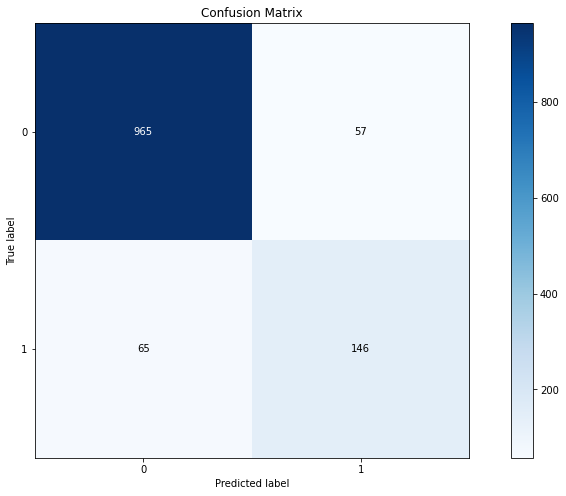

In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test, lgbm_predict )
#Plot the confusion matrix
plot_confusion_matrix(y_test, lgbm_predict, normalize=False,figsize=(15,8))

 **Classification Report**

In [ ]:
class_report= classification_report(y_test, lgbm_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1022
           1       0.72      0.69      0.71       211

    accuracy                           0.90      1233
   macro avg       0.83      0.82      0.82      1233
weighted avg       0.90      0.90      0.90      1233



**Reciever operating characteristics (ROC)- Area under curve(AUC) score**

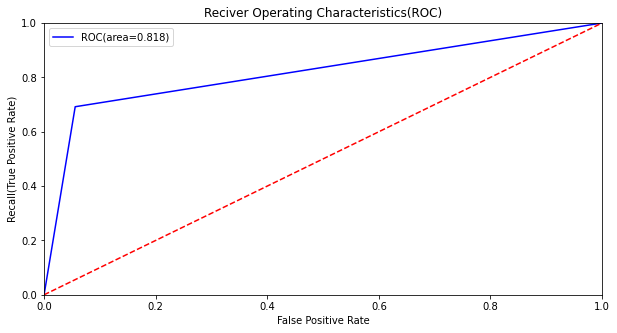

AUC: 0.8180850669164634


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test,lgbm_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* SMOTE sampling is making a significant changes in the LGBM model performance. Recall is 0.69, it is better than 0. Now LGBM clearly distinguishing the classes.

**XGBOOST**

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [ ]:
import xgboost as xgb

#Creating datasets for XGboost
#training data
xgb_train=xgb.DMatrix(X_train_sm,label=y_train_sm, feature_names=X.columns.tolist())
#validation data
xgb_val=xgb.DMatrix(X_val,label=y_val,feature_names=X.columns.tolist())
#validation data
xgb_test=xgb.DMatrix(X_test,label=y_test, feature_names=X.columns.tolist())

Choosing Hyerparameters

In [ ]:
#Selecting best hyperparameters by tuning of different parameters
param={'boosting_type': 'gbtree', 
          'max_depth' : 6,
          'objective': 'binary:logistic',
          'metric':'auc',
          'num_leaves': 30,
          'learning_rate': 0.01,
          'subsample': 0.8,
          'subsample_freq': 10,
          'colsample_bytree': 0.8,
          'bagging_fraction':0.8,
          'bagging_freq':5,
          'lambda_l2':0.4,
          'min_child_samples': 15,
          'random_state':42
          }

Training the XGBoost model

In [ ]:
num_round = 1000
evallist = ([(xgb_val, 'eval'),(xgb_train, 'train')])
bst = xgb.train(param, xgb_train, num_round, evallist,early_stopping_rounds=100)
bst

[0]	eval-error:0.133009	train-error:0.08414
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 100 rounds.
[1]	eval-error:0.131387	train-error:0.083961
[2]	eval-error:0.131387	train-error:0.081212
[3]	eval-error:0.129765	train-error:0.079778
[4]	eval-error:0.131387	train-error:0.077507
[5]	eval-error:0.131387	train-error:0.078762
[6]	eval-error:0.127332	train-error:0.078104
[7]	eval-error:0.127332	train-error:0.078284
[8]	eval-error:0.129765	train-error:0.078045
[9]	eval-error:0.128143	train-error:0.076491
[10]	eval-error:0.128954	train-error:0.074638
[11]	eval-error:0.129765	train-error:0.07661
[12]	eval-error:0.128143	train-error:0.075595
[13]	eval-error:0.128954	train-error:0.075535
[14]	eval-error:0.126521	train-error:0.07673
[15]	eval-error:0.127332	train-error:0.077447
[16]	eval-error:0.128143	train-error:0.076371
[17]	eval-error:0.12571	train-error:0.07679
[18]	eval-error:0.127332	train-error:0.

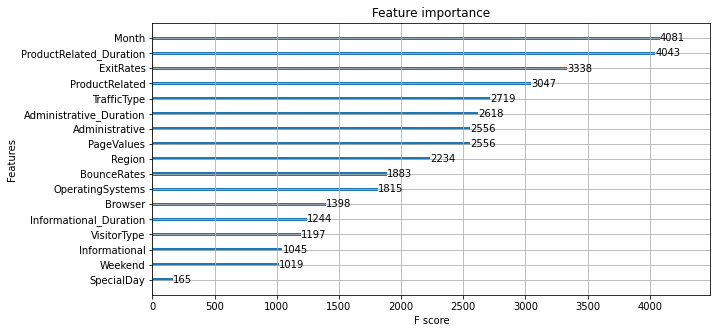

In [ ]:
xgb.plot_importance(bst)

**XGBM model performance on test data**

In [ ]:
# model prediction
#probability predictions
xgbm_pred_prob = bst.predict(xgb_test, ntree_limit=bst.best_ntree_limit)
#Convert to binary output 1 or 0
xgbm_predict=np.where(xgbm_pred_prob>=0.5, 1, 0)
print(xgbm_pred_prob)
print(xgbm_predict)

[0.19790831 0.00500115 0.00674314 ... 0.7160356  0.00204216 0.6762645 ]
[0 0 0 ... 1 0 1]


**Confusion matrix**

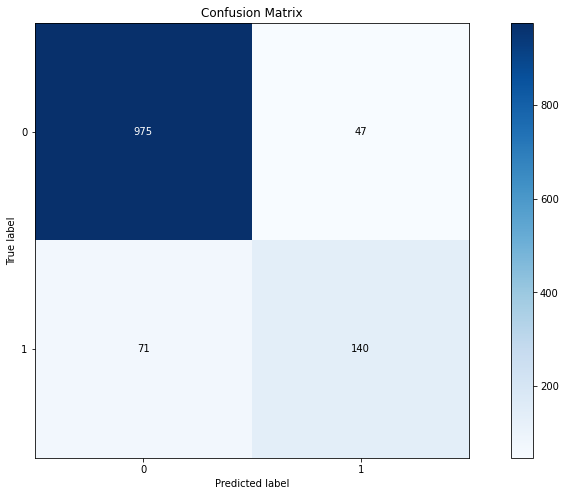

In [ ]:
#Confusion matrix
cm=confusion_matrix(y_test, xgbm_predict )
#Plot the confusion matrix
plot_confusion_matrix(y_test, xgbm_predict, normalize=False,figsize=(15,8))

 **Classification Report**

In [ ]:
class_report= classification_report(y_test, xgbm_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1022
           1       0.75      0.66      0.70       211

    accuracy                           0.90      1233
   macro avg       0.84      0.81      0.82      1233
weighted avg       0.90      0.90      0.90      1233



**Reciever operating characteristics (ROC)- Area under curve(AUC) score**

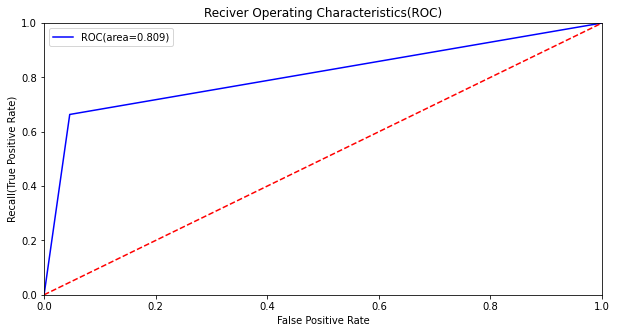

AUC: 0.8087594253438569


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test,xgbm_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* There is a small improvement in XGBM performance with SMOTE sampling. We got recall 0.66, which is 0.07 more than the same model without SMOTE sampling.

In [ ]:
Results={
    'Model':['Base (Logistic Regression)','LGBM','XGBM'],
    'f1-score(with smote)':[0.85, 0.90, 0.90],
    'f1-score(Without smote)':[0.85, 0.75, 0.89],
    'AUC(with smote)':[0.514, 0.818, 0.808],
    'AUC(without smote)':[0.514, 0.5, 0.77]
}

results_df=pd.DataFrame(Results)
results_df

,Model,f1-score(with smote),f1-score(Without smote),AUC(with smote),AUC(without smote)
0,Base (Logistic Regression),0.85,0.85,0.514,0.514
1,LGBM,0.90,0.75,0.818,0.500
2,XGBM,0.90,0.89,0.808,0.770


Insights:
* Among all models, LGBM with SMOTE sampling performing bettter with the AUC score of 0.818.
* 2nd best is XGBM with SMOTE sampling having the AUC score of 0.808.
* Logistic model is a poor classifier for our data. The performance of our model is same for both with SMOTE sampling & without SMOTE data.
* So our study clearly indicates that AUC from ROC curve is the best evaluation metric for highly imbalanced data. We should also need to look at the recall & precision not just at the f1-score while evaluating the performance of ML models.